In [ ]:
/content/drive/My Drive/Datasets/Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from fastai  import *
from fastai.vision import *

In [3]:
path = '/content/drive/My Drive/Datasets/Dataset'

In [4]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path,train=".",valid_pct=0.2,ds_tfms=get_transforms(),size=224,num_workers=4).normalize(imagenet_stats)

In [5]:
data.classes

['black', 'grizzly', 'teddys']

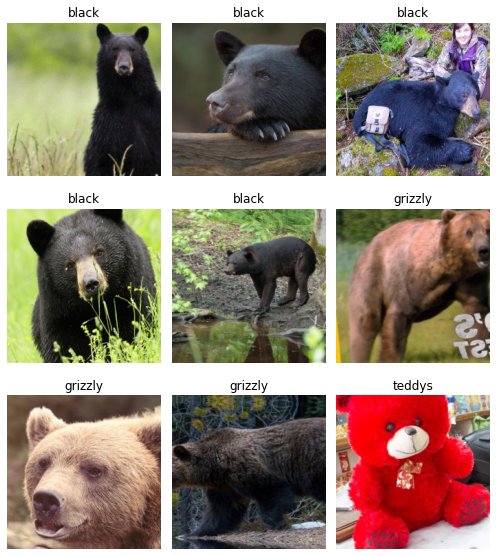

In [6]:
data.show_batch(rows=3,figsize=(7,8))

In [8]:
data.classes,data.c,len(data.train_ds),len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 418, 104)

In [9]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)
learn.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.054396,0.215971,0.057692,01:54
1,0.586707,0.288301,0.048077,00:12
2,0.403537,0.287778,0.038462,00:09
3,0.299283,0.289870,0.038462,00:08


In [10]:
learn.save('stage-1')

In [11]:
learn.unfreeze()

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


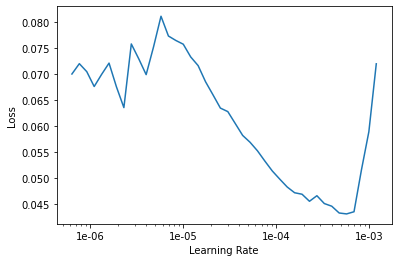

In [13]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.045692,0.261433,0.038462,00:09
1,0.078674,0.270024,0.038462,00:09


In [16]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2')

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

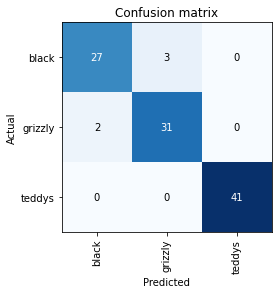

In [19]:
interp.plot_confusion_matrix()

In [25]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.015378,0.280617,0.048077,00:09
1,0.016571,0.302730,0.048077,00:09
2,0.019683,0.318643,0.048077,00:09
3,0.027400,0.271761,0.038462,00:09
4,0.027345,0.343803,0.048077,00:09
5,0.030317,0.373575,0.048077,00:09
6,0.026514,0.383743,0.038462,00:09
7,0.025509,0.372839,0.048077,00:10
8,0.021472,0.369348,0.048077,00:09
9,0.019139,0.370295,0.048077,00:09


And the term we use is "inference". When you are not training a model but you've got a trained model and you're getting it to predict things, we call that inference. That's why we say here:



    You probably want to use CPU for inference


In [26]:
data.classes

['black', 'grizzly', 'teddys']

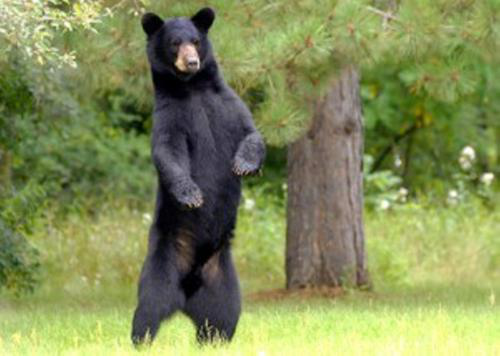

In [28]:
img = open_image('/content/drive/My Drive/Datasets/Dataset/black/00000021.jpg')
img

In [ ]:
classes = ['black', 'grizzly', 'teddys']
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = cnn_learner(data2, models.resnet34)
learn.load('stage-2')

In [35]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category tensor(0)

In [33]:
data.classes

['black', 'grizzly', 'teddys']

# Things that can go wrong 

# 1. Learning rate (LR) too high

So let's grow with our teddy bear detector and let's make our learning rate really high. The default learning rate is 0.003 that works most of the time. So what if we try a learning rate of 0.5. That's huge. What happens? Our validation loss gets pretty darn high. Remember, this is something that's normally something underneath 1. So if you see your validation loss do that, before we even learn what validation loss is, just know this, if it does that, your learning rate is too high. That's all you need to know. Make it lower. Doesn't matter how many epochs you do. If this happens, there's no way to undo this. You have to go back and create your neural net again and fit from scratch with a lower learning rate.

In [36]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

#2. Learning rate (LR) too low

In [37]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,17.319769,346952320.000000,0.682692,00:09


In [40]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,2.124298,2.087950,0.625000,00:08
1,2.130645,1.548002,0.586538,00:08
2,2.088355,1.386594,0.596154,00:08
3,2.053633,1.321169,0.605769,00:08
4,2.001973,1.326105,0.605769,00:09


And you can plot it. So learn.recorder is an object which is going to keep track of lots of things happening while you train. You can call plot_losses to plot out the validation and training loss. And you can just see them gradually going down so slow. If you see that happening, then you have a learning rate which is too small. So bump it by 10 or bump it up by 100 and try again. The other thing you see if your learning rate is too small is that your training loss will be higher than your validation loss. 

### You never want a model where your training loss is higher than your validation loss. 
That always means you haven't fitted enough which means either your learning rate is too low or your number of epochs is too low. So if you have a model like that, train it some more or train it with a higher learning rate.

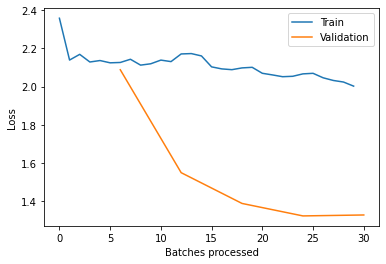

In [42]:
learn.recorder.plot_losses() 
# If learning rate is too small then your training loss is higher than your validation loss

# Too few epochs

What if we train for just one epoch? Our error rate is certainly better than random, 5%. 

### But look at this, the difference between training loss and validation loss ﹣ a training loss is much higher than the validation loss. So too few epochs and too lower learning rate look very similar. So you can just try running more epochs and if it's taking forever, you can try a higher learning rate. If you try a higher learning rate and the loss goes off to 100,000 million, then put it back to where it was and try a few more epochs. That's the balance. That's all you care about 99% of the time. And this is only the 1 in 20 times that the defaults don't work for you.

In [43]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, pretrained=False)

In [44]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.900896,1.108051,0.528846,00:09


# Too many epochs

Too many epochs create something called "**overfitting**". If you train for too long as we're going to learn about it, it will learn to recognize your particular teddy bears but not teddy bears in general. Here is the thing. Despite what you may have heard, it's very hard to overfit with deep learning. So we were trying today to show you an example of overfitting and I turned off everything. I turned off all the data augmentation, dropout, and weight decay. I tried to make it overfit as much as I can. I trained it on a small-ish learning rate, I trained it for a really long time. And maybe I started to get it to overfit. Maybe.

### So the only thing that tells you that you're overfitting is that the error rate improves for a while and then starts getting worse again.

You will see a lot of people, even people that claim to understand machine learning, tell you that if your training loss is lower than your validation loss, then you are overfitting. As you will learn today in more detail and during the rest of course, **that is absolutely not true**.

# Any model that is trained correctly will always have a lower training loss than validation loss.

That is not a sign of overfitting. That is not a sign you've done something wrong. That is a sign you have done something right. The sign that you're overfitting is that your error starts getting worse, because that's what you care about. You want your model to have a low error. So as long as you're training and your model error is improving, you're not overfitting. How could you be?

In [45]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [46]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [47]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.750585,2.180448,0.923241,00:12
1,1.911779,2.093248,0.895522,00:07
2,1.970539,1.991223,0.872068,00:07
3,1.954322,1.825897,0.829424,00:07
4,1.872601,1.615098,0.767591,00:07
5,1.824978,1.358832,0.669510,00:07
6,1.687442,1.099673,0.533049,00:07
7,1.552660,0.853585,0.388060,00:07
8,1.410406,0.650334,0.249467,00:07
9,1.280786,0.503195,0.181237,00:07


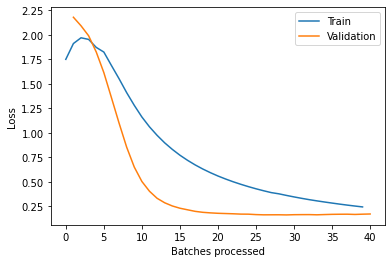

In [48]:
learn.recorder.plot_losses() 

In [49]:
learn.predict??

### Question: Why were you using 3e for your learning rates earlier? With 3e-5 and 3e-4 [59:11]?

We found that 3e-3 is just a really good default learning rate. It works most of the time for your initial fine-tuning before you unfreeze. And then, I tend to kind of just multiply from there. So then the next stage, I will pick 10 times lower than that for the second part of the slice, and whatever the LR finder found for the first part of the slice. The second part of the slice doesn't come from the LR finder. It's just a rule of thumb which is 10 times less than your first part which defaults to 3e-3, and then the first part of the slice is what comes out of the LR finder. We'll be learning a lot more about these learning rate details both today and in the coming lessons. But for now, all you need to remember is that your basic approach looks like this:

    learn.fit_one_cycle
        Some number of epochs, I often pick 4
        Some learning rate which defaults to 3e-3. I'll just type it up fully so you can see.
    Then we do that for a bit and then we unfreeze it.
    Then we learn some more and so this is a bit where I just take whatever I did last time and divide it by 10. Then I also write like that (slice) then I have to put one more number in here and that's the number I get from the learning rate finder﹣a bit where it's got the strongest slope.
